In [100]:
import numpy as np

# Number of parameters to estimate for
numParam = 2

## Data extraction and set up
# Assuming 'OPEC_historical_data.txt' contains the historical OPEC basket price data

with open('OPEC_historical_data.txt', 'r') as pFile:
    pInter = pFile.readlines()

p = [float(value.strip().strip('"')) for value in pInter]

# Get number of terms in time series
M = len(pInter)

# Convert price data to floating point numbers
p = np.array([np.float64(val) for val in pInter])

## If estimating 3 parameters, alpha, beta_1, beta_2
if numParam == 3:
    # f_M column calculation
    f_M = np.zeros(numParam)
    for t in range(2, M):
        f_M += np.array([p[t], p[t-1]*p[t], p[t-2]*p[t]])
    f_M = 1 / (M - 2) * f_M

    # R_M matrix calculation
    r_M = np.zeros((numParam, numParam))
    for t in range(2, M):
        r_M += np.outer(np.array([1, p[t-1], p[t-2]]), np.array([1, p[t-1], p[t-2]]).transpose())
    r_M = 1 / (M - 2) * r_M

    # Calculate optimal parameters
    theta = np.linalg.inv(r_M).dot(f_M)

## If estimating 2 parameters, alpha and beta_1
## Gamma set to -1 (forces sinusoid)
if numParam == 2:
    # f_M column calculation
    f_M = np.zeros(numParam)
    for t in range(2, M):
        f_M += np.array([p[t] + p[t-2], p[t-1]*(p[t] + p[t-2])])
    f_M = 1 / (M - 2) * f_M

    # R_M matrix calculation
    r_M = np.zeros((numParam, numParam))
    for t in range(2, M):
        r_M += np.outer(np.array([1, p[t-1]]), np.array([1, p[t-1]]).transpose())
    r_M = 1 / (M - 2) * r_M

    # Calculate optimal parameters
    theta = np.linalg.inv(r_M).dot(f_M)


In [101]:
theta

array([26.85499962,  1.56551665])

In [151]:
a1 = 103.05
a2 = 106.45
beta_1 = 1.56551665
beta_2 = -1
alpha = 26.85499962
zNaught = [12.20, 11.45, 10.77, 11.26, 12.67, 13.02]


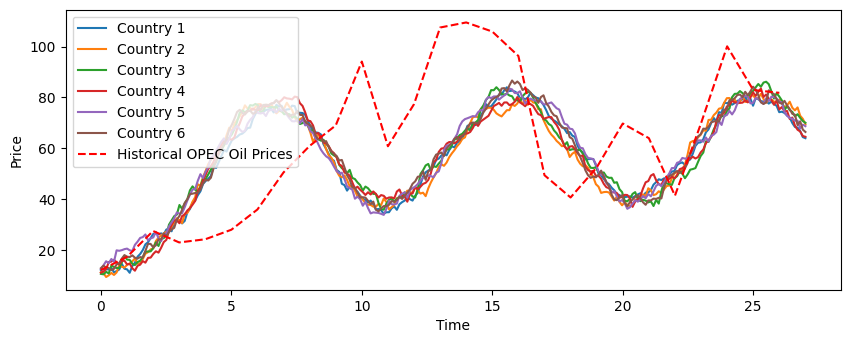

In [173]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats import norm

# Historical OPEC average oil price data
historical_prices = [
    12.28, 17.44, 27.6, 23.12, 24.36, 28.1, 36.05, 50.59, 61, 69.04, 94.1, 60.86, 
    77.38, 107.46, 109.45, 105.87, 96.29, 49.49, 40.76, 52.51, 69.78, 64.04, 41.47, 
    69.89, 100.08, 82.95, 81.83
]

#######################################################
# Solve recurrence relation
#######################################################

# Given parameters
a1 = 13.05
a2 = 16.45
beta_1 = 1.56551665
beta_2 = -1
alpha = 26.85499962

# Calculate continuous parameters
pStar = alpha / (1 - beta_1 - beta_2)
a1 -= pStar
a2 -= pStar
E = (-beta_1 * a1 + a2) / beta_2
F = 1j * (np.power(beta_1, 2) * a1 - beta_1 * a2 + 2 * beta_2 * a1) / (beta_2 * np.sqrt(np.power(beta_1, 2) + 4 * beta_2 + 0j))
theta = np.arccos(beta_1 / (2 * np.sqrt(-beta_2 + 0j)))

# Handle imaginary components
if F.imag == 0:
    F = float(F.real)
if theta.imag == 0:
    theta = float(theta.real)

#######################################################
# Solve homogenous differential equation for psi
#######################################################

# Homogenous system parameters
a = 0.01
b = 1
c = [4, 4, 4, 4, 4, 4]
q = 1
r = 1
lam = 0.5
zNaught = [12.20, 11.45, 10.77, 11.26, 12.67, 13.02]
n = len(zNaught)

# Simulation time parameters
totalT = 27
deltaT = 0.1
T = int(totalT / deltaT)
t = np.linspace(0, 27, num=T)

# Calculate values in ODE
P = (a + np.sqrt(a**2 + b**2 / r * q)) / (b**2 / r)
gam = -np.sqrt(np.power(a, 2) + np.power(b, 2) / r * q)
aODE = 1
bODE = 2 * gam
cODE = -(np.power(a, 2) + np.power(b, 2) / r * lam * q)
refCoeff = -np.power(b, 2) / r * q * lam
r1 = (-bODE + np.sqrt(np.power(bODE, 2) - 4 * aODE * cODE)) / (2 * aODE)
r2 = (-bODE - np.sqrt(np.power(bODE, 2) - 4 * aODE * cODE)) / (2 * aODE)

# Note: Particular solutions were solved analytically outside of this code.

#######################################################
# Solve heterogenous DE for sinusoidal solutions
#######################################################

sinMatrix = np.array([[cODE - np.power(theta, 2), -bODE * theta],
                      [bODE * theta, cODE - np.power(theta, 2)]])
solutionSin = np.array([refCoeff * F, refCoeff * E])
x = np.linalg.solve(sinMatrix, solutionSin)
psiPart = x[0] * np.sin(theta * t) + x[1] * np.cos(theta * t) + pStar
h = F * np.sin(theta * t) + E * np.cos(theta * t) + pStar
homoC = np.average(zNaught) - psiPart[0]
psi = x[0] * np.sin(theta * t) + x[1] * np.cos(theta * t) + pStar + homoC * np.exp(r2 * t)

#####################################################
# Solve heterogenous DE for exponential solutions
#####################################################

refA1 = ((E - F * 1j) / 2).real
refA2 = ((E + F * 1j) / 2).real
refGam1 = ((1j * theta + np.log(-beta_2) / 2))
refGam2 = ((-1j * theta + np.log(-beta_2) / 2))

# Define functions for exponential solutions
def psiExpSol(t):
    return (refCoeff * refA1 / (np.power(refGam1, 2) - bODE * refGam1 + cODE) * np.exp(refGam1 * t) +
            refCoeff * refA2 / (np.power(refGam2, 2) - bODE * refGam2 + cODE) * np.exp(refGam2 * t) +
            refCoeff * pStar / cODE).real

def hExp(t):
    return (np.power((-beta_2), t / 2) * ((E - F * 1j) / 2 * np.exp(1j * theta * t) +
                                          (E + F * 1j) / 2 * np.exp(-1j * theta * t)) + pStar).real

homoCExp = np.average(zNaught) - psiExpSol(0)

#############################################################
# Solve heterogenous DE for exponential sinusoidal solutions
#############################################################

rSin = np.log(-beta_2) / 2
sinExpMatrix = np.array([[np.power(rSin, 2) - np.power(theta, 2) + bODE * rSin + cODE, 2 * theta * rSin + bODE * theta],
                         [-2 * theta * rSin - bODE * theta, np.power(rSin, 2) - np.power(theta, 2) + bODE * rSin + cODE]])
solutionSinExp = np.array([refCoeff * F, refCoeff * E])
xSinExp = np.linalg.solve(sinExpMatrix, solutionSinExp)
psiSinExpPart = np.exp(rSin * t) * (x[0] * np.sin(theta * t) + x[1] * np.cos(theta * t)) + pStar
hSinExp = np.exp(rSin * t) * (F * np.sin(theta * t) + E * np.cos(theta * t)) + pStar
homoCSinExp = np.average(zNaught) - psiSinExpPart[0]

############################################################
# Simulations
############################################################

# Define functions for s variable integrals
def sIntegralSin(tau, tConst):
    return np.exp(gam * (tau - tConst)) * q * ((1 - lam) * (x[0] * np.sin(theta * tau) + x[1] * np.cos(theta * tau) +
                                                           pStar + homoC * np.exp(r2 * tau)) +
                                                lam * (F * np.sin(theta * tau) + E * np.cos(theta * tau) + pStar))

# Compute s variable
s = []
for timeStep in range(0, T):
    tea = deltaT * timeStep
    integral, err = sc.integrate.quad(sIntegralSin, tea, np.inf, args=tea)
    s.append(-integral)

# Initialize variables for Brownian motion
dz = []
zAll = []
uAll = []
delta = 1

# Simulate agent behaviors
for i in range(0, n):
    dz = []
    z = [zNaught[i]]
    u = []
    w = [np.float64(0)]  # Initial condition for Brownian motion

    # Compute Brownian motion steps
    for timeStep in range(1, T):
        w.append(w[timeStep - 1] + np.float64(norm.rvs(scale=delta ** 2 * np.sqrt(deltaT))))

    # Compute predicted prices of agents
    for timeStep in range(0, T - 1):
        tea = deltaT * timeStep
        u.append(-b / r * (P * z[timeStep] + s[timeStep]))
        dz.append((a * z[timeStep] + b * u[timeStep]) * deltaT +
                  c[i] * (w[timeStep + 1] - w[timeStep])) 
        z.append(z[timeStep] + dz[timeStep])

    uAll.append(u)
    zAll.append(z)

# Plot results
plt.figure(figsize=(10, 8))


plt.subplot(2, 1, 2)
for i in range(n):
    plt.plot(t, zAll[i], label=f"Country {i+1}")
plt.plot(range(len(historical_prices)), historical_prices, label="Historical OPEC Oil Prices", linestyle='--', color='red')
plt.legend()
plt.ylabel("Price")
plt.xlabel("Time")
plt.show()
